# Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
from sklearn.metrics import f1_score

In [3]:
DATA_PATH = "data"

def load_data(path=DATA_PATH):
    def get_path(set_type, is_args):
        return os.path.join(DATA_PATH, set_type, ("arguments" if is_args else "labels") + "-" + set_type + ".tsv")
    
    data = {}
    
    for set_type in ["test", "training", "validation"]:
        args = pd.read_csv(get_path(set_type, True), sep="\t")
        
        labels = pd.read_csv(get_path(set_type, False), sep="\t")
        labels = labels.drop("Argument ID", axis=1)
        args["Labels"] = [x for x in labels.to_numpy()]
        
        data[set_type] = args
        print(f"Set:{set_type.title()} - Size:{args.shape[0]}")
        
    classes = list(labels.columns)
    
    return data, classes

data, classes = load_data()
data["training"].head()

Set:Test - Size:1576
Set:Training - Size:5393
Set:Validation - Size:1896


,Argument ID,Conclusion,Stance,Premise,Labels
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ..."
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."


# Pre-processing

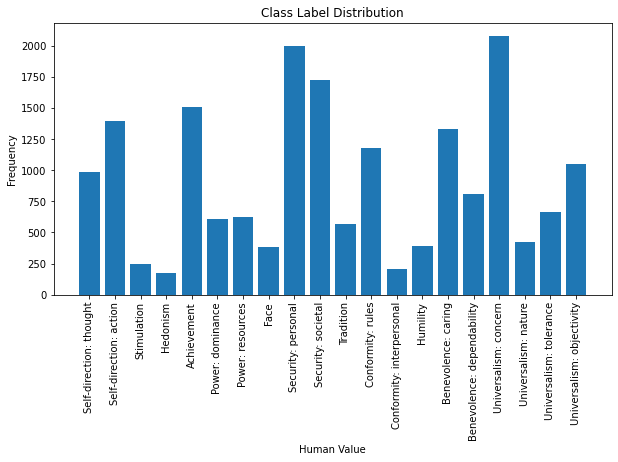

In [4]:
data_counts = data["training"]['Labels'].sum(axis=0)
fig = plt.figure(figsize = (10, 5))

plt.bar(classes, data_counts)

plt.xlabel("Human Value")
plt.xticks(rotation='vertical')
plt.ylabel("Frequency")
plt.title("Class Label Distribution")
plt.show()

### Data augmentation

In [5]:
RUN_AUG = False

if RUN_AUG:
    trans_en_ru = pipeline("text2text-generation", model="Helsinki-NLP/opus-mt-en-ru")
    trans_ru_en = pipeline("text2text-generation", model="Helsinki-NLP/opus-mt-ru-en")

    def rus_back_trans(text, trans_to, trans_back):
        aug_sent = trans_back(trans_to(text)[0]['generated_text'])
        return aug_sent[0]['generated_text']

    augmentations = []
    i = 0
    premises = data["training"]['Premise']
    
    for premise in premises:
        if i % 100 == 0: print(i)
        augmentations.append(rus_back_trans(premise, trans_en_ru, trans_ru_en))
        i += 1

    np.save('./back_trans_augm.npy', augmentations)

In [6]:
data["training"]['Rus-back-trans'] = np.load('./back_trans_augm.npy')
data["training"].head()

,Argument ID,Conclusion,Stance,Premise,Labels,Rus-back-trans
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","We must ban human cloning, because it will cau..."
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",Rapid food must be banned because it is very u...
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",Sometimes economic sanctions are the only thin...
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...",The death penalty is sometimes the only way to...
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...",Farms produce the cheap food needed for low-in...


In [ ]:
# import nlpaug.augmenter.char as nac
# import nlpaug.augmenter.word as naw
# import nlpaug.augmenter.sentence as nas
# import nlpaug.flow as nafc
# from nltk.corpus import stopwords

# from nlpaug.util import Action

# stopWords = set(stopwords.words('english'))

# text = data['training'][0]['Premise']
# # text = probes[0]['generated_text']
# aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.4, stopwords=stopWords)
# augmented_text = aug.augment(text)
# print("Original:")
# print(text)
# print("Augmented Text:")
# print(augmented_text)

In [ ]:

# paraphraser = pipeline("text2text-generation", model="humarin/chatgpt_paraphraser_on_T5_base")

# phrase_ex = data['training'][0]['Premise']
# num_paraphrased = 1
# probes = paraphraser(phrase_ex, num_return_sequences=num_paraphrased)
# print(phrase_ex)
# print(probes[0])


# Model

In [ ]:
def accuracy_thresh(y_pred, y_true, thresh=0.5, sigmoid=True):
    """Compute accuracy of predictions"""
    y_pred = torch.from_numpy(y_pred)
    y_true = torch.from_numpy(y_true)
    if sigmoid:
        y_pred = y_pred.sigmoid()

    return ((y_pred > thresh) == y_true.bool()).float().mean().item()


def f1_score_per_label(y_pred, y_true, value_classes, thresh=0.5, sigmoid=True):
    """Compute label-wise and averaged F1-scores"""
    y_pred = torch.from_numpy(y_pred)
    y_true = torch.from_numpy(y_true)
    if sigmoid:
        y_pred = y_pred.sigmoid()

    y_true = y_true.bool().numpy()
    y_pred = (y_pred > thresh).numpy()

    f1_scores = {}
    for i, v in enumerate(value_classes):
        f1_scores[v] = round(f1_score(y_true[:, i], y_pred[:, i], zero_division=0), 2)

    f1_scores['avg-f1-score'] = round(np.mean(list(f1_scores.values())), 2)

    return f1_scores


def compute_metrics(eval_pred, value_classes):
    """Custom metric calculation function for MultiLabelTrainer"""
    predictions, labels = eval_pred
    f1scores = f1_score_per_label(predictions, labels, value_classes)
    return {'accuracy_thresh': accuracy_thresh(predictions, labels), 'f1-score': f1scores,
            'marco-avg-f1score': f1scores['avg-f1-score']}

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


def encode(str_input):
    return tokenizer(str_input, truncation=True)

test_data = data["training"]["Premise"]
test_data = test_data.map(encode)
val_data = data["validation"]["Premise"]
val_data = val_data.map(encode)

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", 
                                                           num_labels=len(classes)) 
                                                           #problem_type="multi_label_classification")

training_args = TrainingArguments(
    output_dir="models",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='marco-avg-f1score',
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=test_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    compute_metrics=lambda x: compute_metrics(x, labels),
)

trainer.train()
